# Training set variability

In [1]:
library(tidyverse)

theme_update(text = element_text(size=24))
options(repr.plot.width=12, repr.plot.height=6)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

In [2]:
# fage: Father's age in years.
# mage: Mother's age in years.
# mature: Maturity status of mother.
# weeks: Length of pregnancy in weeks.
# premie: Whether the birth was classified as premature (premie) or full-term.
# visits: Number of hospital visits during pregnancy.
# gained: Weight gained by mother during pregnancy in pounds.
# weight: Weight of the baby at birth in pounds.
# lowbirthweight: Whether baby was classified as low birthweight (low) or not (not low).
# sex: Sex of the baby, female or male.
# habit: Status of the mother as a nonsmoker or a smoker.
# marital: Whether mother is married or not married at birth.
# whitemom: Whether mom is white or not white.

df_raw <- read.csv("../datasets/births14.csv")

In [3]:
# Drop missing data
df_raw %>% summarise_all(~ sum(is.na(.)))
df <- df_raw %>% drop_na(everything())
cat("Dropped ", nrow(df_raw) - nrow(df), " rows \n")
head(df)

# Meaning of truncated variables
df %>% group_by(mature) %>% summarize(min(mage), max(mage))
df %>% group_by(premie) %>% summarize(min(weeks), max(weeks))
df %>% group_by(lowbirthweight) %>% summarize(min(weight), max(weight))

Dropped  206  rows 

In [4]:
y_col <- "weight"
# We don't want to deal with collinear regressors in small samples
#x_cols <- c("mage", "fage", "sex", "habit", "marital")
x_cols <- c("mage", "fage", "sex")
reg_form <- sprintf("%s ~ 1 + %s", y_col, paste(x_cols, collapse=" + "))
x_all <- model.matrix(formula(reg_form), df)
y_all <- df[[y_col]]

n_all <- length(y_all)
stopifnot(nrow(x_all) == n_all)

In [5]:
# Let's look at a single test point
test_ind <- sample(n_all, 1) # Choose a single test point
x_test <- x_all[test_ind, ]
y_test <- y_all[test_ind]

In [6]:
# Sanity check that lm() is doing what we expect
n_obs <- 500
train_inds <- sample(setdiff(n_all, test_ind), n_obs, replace=FALSE)
x <- x_all[train_inds, ]
y <- y_all[train_inds]
reg_fit <- lm(formula(reg_form), df[train_inds, ])

betahat <- solve(t(x) %*% x, t(x) %*% y)

bind_cols(
  coefficients(reg_fit),
  betahat)

res <- y - x %*% betahat
max(abs(res - summary(reg_fit)$residual))

sigmasqhat <- sum((y - x %*% betahat)^2) / (nrow(x) - ncol(x))
c(sigmasqhat, summary(reg_fit)$sigma^2)

New names:
• `` -> `...1`
• `` -> `...2`

7.70494779089859e-14

1.66686348025497 1.66686348025497

In [10]:
num_sims <- 20
n_obs <- 500
stopifnot(n_obs < n_all - 1)

intervals_df <- data.frame()
for (sim_ind in 1:num_sims) {
    train_inds <- sample(setdiff(n_all, test_ind), n_obs, replace=FALSE)
    reg_fit <- lm(formula(reg_form), df[train_inds, ])
    betahat <- coefficients(reg_fit)
    sigmahat <- summary(reg_fit)$sigma

    miscoverage_prob <- 0.2
    za <- qnorm(1 - miscoverage_prob / 2)

    y_pred <- sum(betahat * x_test)
    width_pred <- za * sigmahat

    intervals_df <- bind_rows(
      intervals_df,
      data.frame(sim_ind=sim_ind, 
                 y_pred=y_pred, 
                 width_pred=width_pred, 
                 y_test=y_test,
                 n_obs=n_obs)
    )
}

ggplot(intervals_df) +
  geom_point(aes(x=sim_ind, y=y_test), color="red", size=3) +
  geom_errorbar(aes(x=sim_ind, ymin=y_pred - width_pred, ymax=y_pred + width_pred),
                width=0.1) +
  xlab("Simulation number (order doesn't matter)") +
  ylab("Weight at birth (pounds)\nPredictive intervals and (unobserved) truth")
   


In [7]:
num_sims <- 20
intervals_df <- data.frame()

for (n_obs in c(30, 50, 100, 200, 500)) {
  stopifnot(n_obs < n_all - 1)
  
  for (sim_ind in 1:num_sims) {
    train_inds <- sample(setdiff(n_all, test_ind), n_obs, replace=FALSE)
    reg_fit <- lm(formula(reg_form), df[train_inds, ])
    betahat <- coefficients(reg_fit)
    sigmahat <- summary(reg_fit)$sigma
    
    miscoverage_prob <- 0.2
    za <- qnorm(1 - miscoverage_prob / 2)
    
    y_pred <- sum(betahat * x_test)
    width_pred <- za * sigmahat
    
    intervals_df <- bind_rows(
      intervals_df,
      data.frame(sim_ind=sim_ind, 
                 y_pred=y_pred, 
                 width_pred=width_pred, 
                 y_test=y_test,
                 n_obs=n_obs)
    )
  }
}

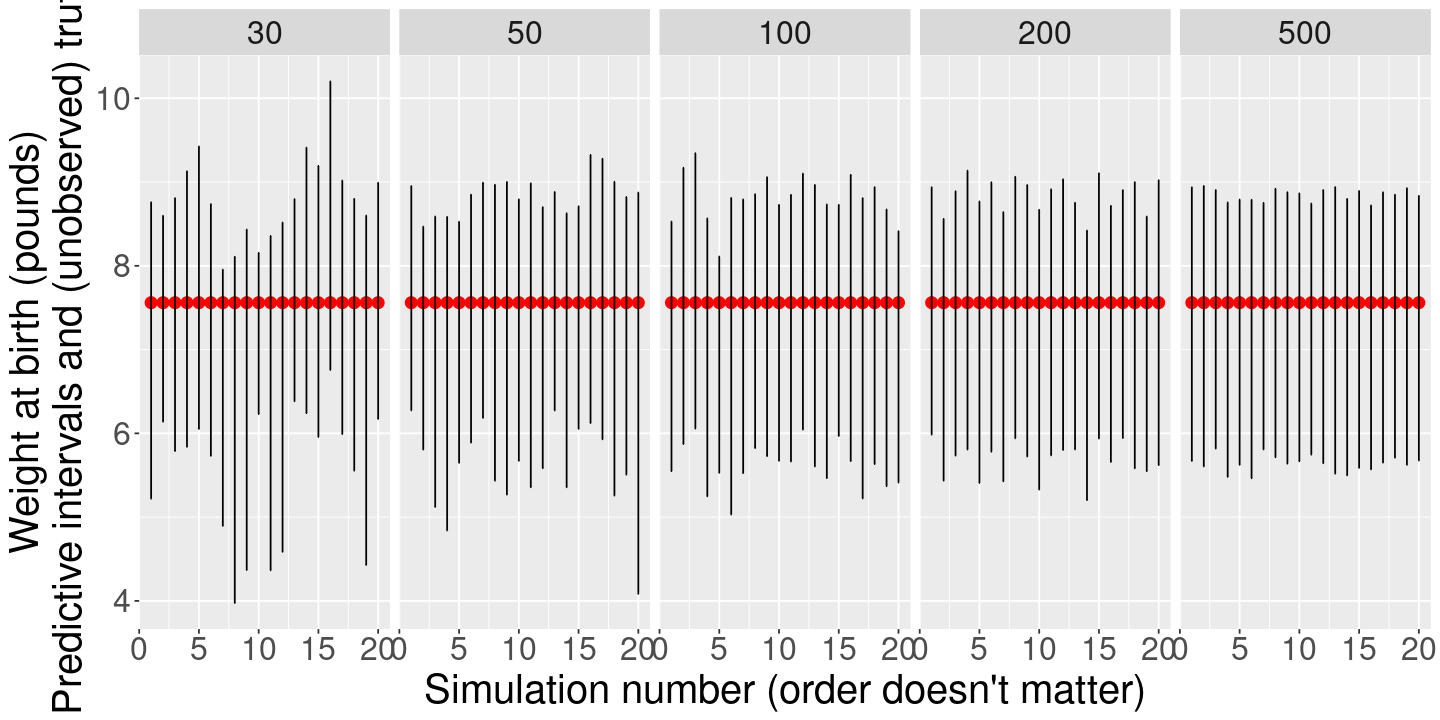

In [9]:
ggplot(intervals_df) +
  geom_point(aes(x=sim_ind, y=y_test), color="red", size=3) +
  geom_errorbar(aes(x=sim_ind, ymin=y_pred - width_pred, ymax=y_pred + width_pred),
                width=0.1) +
  xlab("Simulation number (order doesn't matter)") +
  ylab("Weight at birth (pounds)\nPredictive intervals and (unobserved) truth") +
  facet_grid(.~n_obs)
   